<a href="https://colab.research.google.com/github/naksh-atra/Cats_Gen/blob/main/CatImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/100] Batch 0/2 Loss D: 1.4201, Loss G: 3.1151 D(x): 0.5082, D(G(z)): 0.0470
Epoch [2/100] Batch 0/2 Loss D: 0.8672, Loss G: 4.1836 D(x): 0.7127, D(G(z)): 0.0167
Epoch [3/100] Batch 0/2 Loss D: 0.7037, Loss G: 5.2501 D(x): 0.8162, D(G(z)): 0.0057
Epoch [4/100] Batch 0/2 Loss D: 0.6340, Loss G: 6.3546 D(x): 0.8298, D(G(z)): 0.0019
Epoch [5/100] Batch 0/2 Loss D: 0.4729, Loss G: 7.0570 D(x): 0.8561, D(G(z)): 0.0010
Epoch [6/100] Batch 0/2 Loss D: 0.5073, Loss G: 8.5777 D(x): 0.9028, D(G(z)): 0.0002
Epoch [7/100] Batch 0/2 Loss D: 0.4398, Loss G: 8.9530 D(x): 0.9085, D(G(z)): 0.0002
Epoch [8/100] Batch 0/2 Loss D: 0.3685, Loss G: 9.6995 D(x): 0.9182, D(G(z)): 0.0001
Epoch [9/100] Batch 0/2 Loss D: 0.2595, Loss G: 9.0222 D(x): 0.9280, D(G(z)): 0.0001
Epoch [10/100] Batch 0/2 Loss D: 0.3494, Loss G: 11.2278 D(x): 0.9266, D(G(z)): 0.0000
Epoch [11/100] Batch 0/2 Loss D: 0.0691, Loss G: 6.7755 D(x): 0.9396, D(G(z)): 0.0015
Epoch [12/100] Batch 0/2 Loss D: 0.1144, Loss G: 12.1314 D(x):

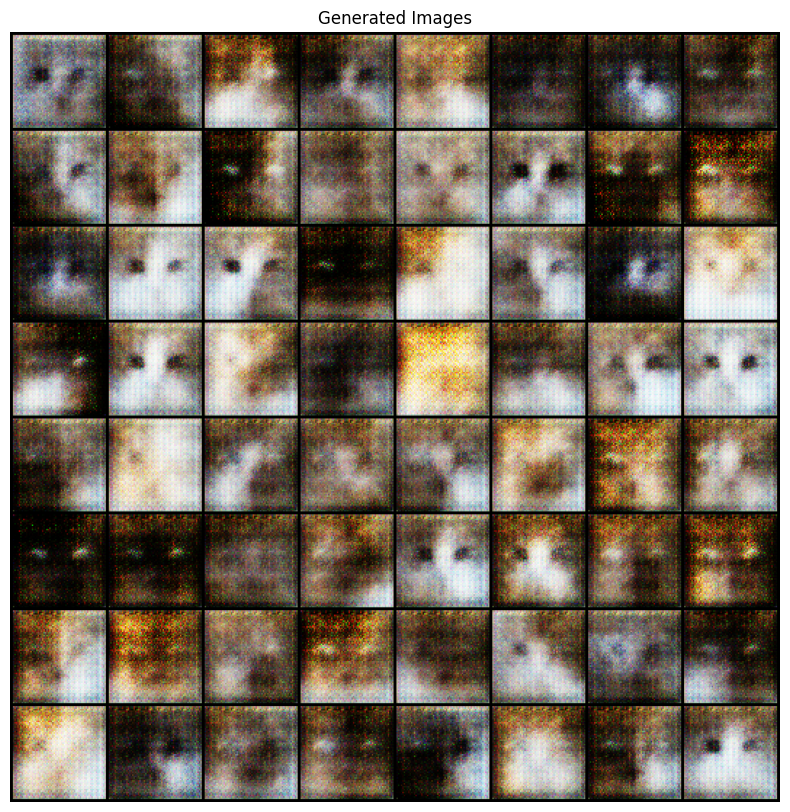

In [5]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np


# Hyperparameters
data_dir = '/content/CatsCats'
image_size = 64
batch_size = 128
num_epochs = 100
learning_rate = 0.0002
beta1 = 0.5
nz = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = 'output_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#dataset
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageDataset(image_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


#Generator
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

#Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)

#model initializing
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

#loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

#trainning loop
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create real labels with dtype float
        label = torch.full((batch_size,), 1, device=device).float()
        output = netD(real_images)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)

        # Create fake labels with dtype float
        label.fill_(0)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()

        # Fake labels are real for generator cost
        label.fill_(1)
        output = netD(fake_images)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()

        # Print stats
        if i % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(dataloader)} '
                  f'Loss D: {lossD_real.item()+lossD_fake.item():.4f}, Loss G: {lossG.item():.4f} '
                  f'D(x): {D_x:.4f}, D(G(z)): {output.mean().item():.4f}')

# Save fake images
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()
        vutils.save_image(fake_images, os.path.join(output_dir, f'fake_samples_epoch_{epoch+1}.png'), normalize=True)


# Visualizing the output imgs
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

# pytorch saving
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')
